In [2]:
# SETUP
# optbinning is the "Secret Weapon" used by top banks for Scorecard development
!pip install optbinning xgboost scikit-learn pandas matplotlib -q
print("Environment Ready.")

Environment Ready.


--- Step 1: Simulating Credit Bureau & Alternative Data ---
Data Generated: (15000, 6)
Default Rate: 26.84%

--- Step 2: Training Traditional Scorecard (WoE) ---
Traditional Model AUC: 0.7082

--- Step 3: Training AI Challenger (XGBoost) ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:23:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Challenger AI Model AUC: 0.7190
AUC Uplift: +0.0108

--- Step 4: Maximizing Profit ---


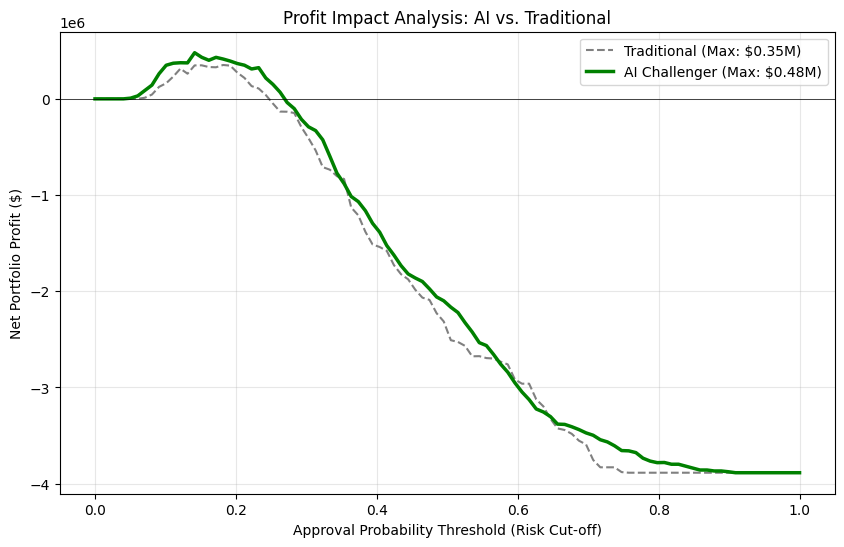

💰 Financial Result:
Traditional Max Profit: $352,200.00
AI Challenger Max Profit: $479,600.00
🚀 Net Revenue Increase: $127,400.00 (+36.2%)

--- Step 5: Who did the AI save? (Swap Set) ---
Customers Rejected by Banker but Approved by AI: 62
Performance of these 'AI-Found' Customers: 88.7% Repayment Rate
Interpretation: The AI successfully identified 'Thin-File' borrowers who are trustworthy.


In [3]:
# CREDIT DECISION ENGINE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier
from optbinning import BinningProcess # The "Gold Standard" for Credit Scoring

# Reproducibility
np.random.seed(42)


# 1. SYNTHETIC DATA GENERATION

print("--- Step 1: Simulating Credit Bureau & Alternative Data ---")

def generate_credit_data(n=15000):
    """
    Simulates a 'Thin-File' scenario where traditional metrics (Income/Debt)
    miss good borrowers who are revealed by Alternative Data (Utility consistency).
    """
    # 1. Traditional Bureau Data
    age = np.random.normal(35, 12, n).astype(int)
    age = np.clip(age, 18, 70)
    income = np.random.normal(55000, 18000, n)
    income = np.clip(income, 15000, 150000)
    debt_ratio = np.random.beta(2, 5, n) # Skewed towards lower debt

    # 2. Alternative "Fintech" Data
    # utility_consistency: 0.0 (misses payments) to 1.0 (perfect history)
    utility_consistency = np.random.beta(7, 2, n)
    app_usage_hours = np.random.gamma(2, 2, n) # How often they check financial app

    # 3. Create Target (Default = 1, Good = 0)
    # The Logic: Risk is driven by debt/income, BUT high utility consistency lowers risk dramatically
    risk_score = (debt_ratio * 5) - (income/80000) - (utility_consistency * 2.5) + (np.random.normal(0, 0.5, n))

    # Sigmoid to get probability
    prob_default = 1 / (1 + np.exp(-risk_score))
    default_status = (np.random.rand(n) < prob_default).astype(int)

    df = pd.DataFrame({
        'Age': age,
        'Income': income,
        'Debt_Ratio': debt_ratio,
        'Utility_Consistency': utility_consistency, # Alt Data
        'App_Usage': app_usage_hours, # Alt Data
        'Default': default_status
    })
    return df

df = generate_credit_data()
X = df.drop('Default', axis=1)
y = df['Default']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Generated: {df.shape}")
print(f"Default Rate: {y.mean():.2%}")


# 2. TRACK A: THE "BANKER" (Regulatory Model)

print("\n--- Step 2: Training Traditional Scorecard (WoE) ---")
# Banks MUST use "Explainable" models. We use Weight of Evidence (WoE) binning.
# We ONLY show this model Traditional data (Age, Income, Debt).

trad_features = ['Age', 'Income', 'Debt_Ratio']

# Binning Process (Handles outliers and non-linearity legally)
binning_process = BinningProcess(variable_names=trad_features)
X_train_binned = binning_process.fit_transform(X_train[trad_features], y_train)
X_test_binned = binning_process.transform(X_test[trad_features])

# Logistic Regression (The standard for Scorecards)
trad_model = LogisticRegression()
trad_model.fit(X_train_binned, y_train)

# Predict
y_pred_trad = trad_model.predict_proba(X_test_binned)[:, 1]
auc_trad = roc_auc_score(y_test, y_pred_trad)
print(f"Traditional Model AUC: {auc_trad:.4f}")


# 3. TRACK B: THE "CHALLENGER" (AI Model)

print("\n--- Step 3: Training AI Challenger (XGBoost) ---")
# The AI gets to see EVERYTHING (Traditional + Alternative Data).
# It uses non-linear trees to find complex patterns.

challenger_model = XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    eval_metric='logloss',
    use_label_encoder=False
)

challenger_model.fit(X_train, y_train)

# Predict
y_pred_chal = challenger_model.predict_proba(X_test)[:, 1]
auc_chal = roc_auc_score(y_test, y_pred_chal)
print(f"Challenger AI Model AUC: {auc_chal:.4f}")
print(f"AUC Uplift: +{auc_chal - auc_trad:.4f}")

# 4. STRATEGY: FINANCIAL IMPACT ANALYSIS

print("\n--- Step 4: Maximizing Profit ---")

def calculate_profit_curve(y_true, y_probs, loan_amt=10000, interest_rate=0.15):
    """
    Calculates Net Profit at every possible approval threshold.
    Profit = (Interest Earned from Good Loans) - (Principal Lost from Defaults)
    """
    thresholds = np.linspace(0, 1, 100)
    profits = []

    # We lose the full loan amount on default, but gain only interest on repayment
    loss_per_default = -loan_amt
    gain_per_repayment = loan_amt * interest_rate

    for t in thresholds:
        # Policy: Approve if Prob(Default) < t
        approvals = y_probs < t

        # Financials
        tp = np.sum((approvals) & (y_true == 0)) # Good Loan Approved
        fp = np.sum((approvals) & (y_true == 1)) # Bad Loan Approved (Default)

        net_profit = (tp * gain_per_repayment) + (fp * loss_per_default)
        profits.append(net_profit)

    return thresholds, np.array(profits)

# Assumptions
LOAN_AMT = 10000
INTEREST = 0.18 # 18% APR

thresh_trad, profit_trad = calculate_profit_curve(y_test, y_pred_trad, LOAN_AMT, INTEREST)
thresh_chal, profit_chal = calculate_profit_curve(y_test, y_pred_chal, LOAN_AMT, INTEREST)

max_profit_trad = np.max(profit_trad)
max_profit_chal = np.max(profit_chal)
uplift_usd = max_profit_chal - max_profit_trad

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(thresh_trad, profit_trad, label=f'Traditional (Max: ${max_profit_trad/1e6:.2f}M)', linestyle='--', color='gray')
plt.plot(thresh_chal, profit_chal, label=f'AI Challenger (Max: ${max_profit_chal/1e6:.2f}M)', color='green', linewidth=2.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.title("Profit Impact Analysis: AI vs. Traditional")
plt.xlabel("Approval Probability Threshold (Risk Cut-off)")
plt.ylabel("Net Portfolio Profit ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"💰 Financial Result:")
print(f"Traditional Max Profit: ${max_profit_trad:,.2f}")
print(f"AI Challenger Max Profit: ${max_profit_chal:,.2f}")
print(f"🚀 Net Revenue Increase: ${uplift_usd:,.2f} (+{(uplift_usd/max_profit_trad)*100:.1f}%)")

# 5. SWAP SET ANALYSIS (Invisible Primes)

print("\n--- Step 5: Who did the AI save? (Swap Set) ---")
# We set the cutoff at the point of max profit for both models
cutoff_trad = thresh_trad[np.argmax(profit_trad)]
cutoff_chal = thresh_chal[np.argmax(profit_chal)]

# Identify decisions
trad_approved = y_pred_trad < cutoff_trad
chal_approved = y_pred_chal < cutoff_chal

# "Swap-Ins": People the Old Model Rejected, but AI Approved
swap_ins = (~trad_approved) & (chal_approved)
num_swap_ins = np.sum(swap_ins)
# Of the people we swapped in, how many actually paid us back?
good_rate_swap_ins = 1 - np.mean(y_test[swap_ins])

print(f"Customers Rejected by Banker but Approved by AI: {num_swap_ins}")
print(f"Performance of these 'AI-Found' Customers: {good_rate_swap_ins:.1%} Repayment Rate")
print("Interpretation: The AI successfully identified 'Thin-File' borrowers who are trustworthy.")